Question 1

In [31]:
import cv2
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import math
f =  cv2.imread('the_berry_farms_sunflower_field.jpeg',cv2.IMREAD_REDUCED_COLOR_4)#gray scale conversion
f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)  # OpenCV loads images in BGR format, convert to RGB

# Convert the color image to grayscale
img = cv2.cvtColor(f, cv2.COLOR_RGB2GRAY)

from scipy import ndimage
from scipy.ndimage import filters
from scipy import spatial
k = 1.414
sigma = 1.0
img = img/255.0  #image normalization

In [32]:
def laplacian_of_gaussian(s):
    n = np.ceil(s * 6)
    y, x = np.ogrid[-n//2:n//2+1, -n//2:n//2+1]
    log = 1 / (2 * np.pi * s**2) * (x**2 / (s**2) + y**2 / (s**2) - 2) * np.exp(-(x**2 + y**2) / (2 * s**2))
    return log


In [33]:
def log_convolve(img):
    scale_space = [] 
    for j in range(0,9):
        y = np.power(k,j) 
        sigma_1 = sigma*y
        filter_log = laplacian_of_gaussian(sigma_1) 
        image = cv2.filter2D(img,-1,filter_log) 
        image = np.pad(image,((1,1),(1,1)),'constant') 
        image = np.square(image)
        scale_space.append(image)
    scale_space_np = np.array([i for i in scale_space]) 
    
    return scale_space_np
scale_space_np = log_convolve(img)

In [34]:
def detect_blob(log_image_np):
    co_ordinates = [] 
    (h,w) = img.shape
    for i in range(1,h):
        for j in range(1,w):
            imgs = log_image_np[:,i-1:i+2,j-1:j+2] 
            result = np.amax(imgs) 
            if result >= 0.03: 
                z,x,y = np.unravel_index(imgs.argmax(),imgs.shape)
                co_ordinates.append((i+x-1,j+y-1,k**z*sigma)) 
    return co_ordinates
co_ordinates = list(set(detect_blob(scale_space_np)))

In [35]:
def blob_overlap(blob1, blob2):
    n_dim = len(blob1) - 1
    root_ndim = sqrt(n_dim)
    
    r1 = blob1[-1] * root_ndim
    r2 = blob2[-1] * root_ndim
    
    d = sqrt(np.sum((blob1[:-1] - blob2[:-1])**2))
    
    if d > r1 + r2:
        return 0
    elif d <= abs(r1 - r2):
        return 1
    else:
        ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
        ratio1 = np.clip(ratio1, -1, 1)
        acos1 = math.acos(ratio1)
        ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
        ratio2 = np.clip(ratio2, -1, 1)
        acos2 = math.acos(ratio2)
        a = -d + r2 + r1
        b = d - r2 + r1
        c = d + r2 - r1
        d = d + r2 + r1
        area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -0.5 * sqrt(abs(a * b * c * d)))
        return area/(math.pi * (min(r1, r2) ** 2))

In [36]:
#function to obtain only the non overlapping blobs from an array of overlapping blobs
def redundancy(blobs_array, overlap):
    sigma = blobs_array[:, -1].max()
    distance = 2 * sigma * sqrt(blobs_array.shape[1] - 1)
    tree = spatial.cKDTree(blobs_array[:, :-1])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_array
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if blob_overlap(blob1, blob2) > overlap:
                if blob1[-1] > blob2[-1]:
                    blob2[-1] = 0
                else:
                    blob1[-1] = 0
    return np.array([b for b in blobs_array if b[-1] > 0])



In [37]:
co_ordinates = np.array(co_ordinates)
co_ordinates = redundancy(co_ordinates,0.5)

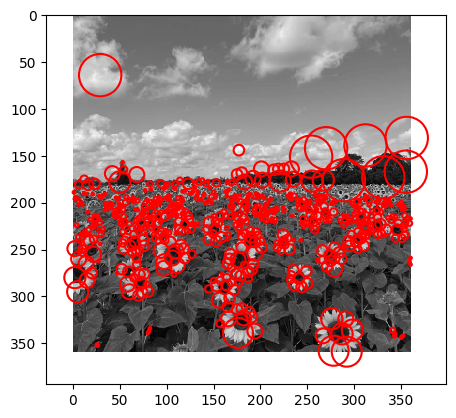

In [38]:
fig, ax = plt.subplots()
nh,nw = img.shape
count = 0
ax.imshow(img, interpolation='nearest',cmap="gray")
for blob in co_ordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*1.414, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()  
plt.show()

Question 2

In [2]:
pip install tikzplotlib

  Using cached tikzplotlib-0.10.1-py3-none-any.whl (54 kB)
  Using cached webcolors-1.13-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


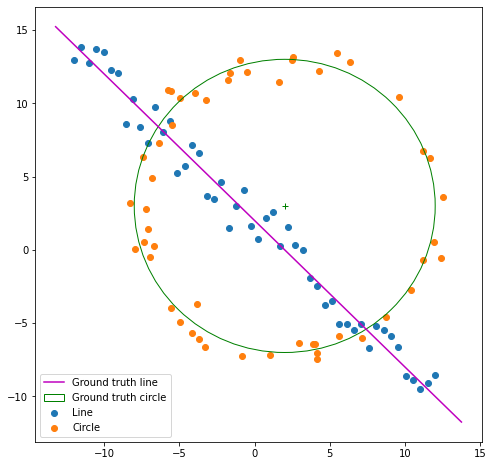

In [3]:
from scipy . optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib
import numpy as np
# np . random . seed ( 0 )
num_points = 100
half_n = num_points//2
r = 10
x0_gt , y0_gt = 2 , 3 # Center
s = r /16
threshold = np.random.uniform(0 , 2*np . pi , half_n )
n = s*np.random.randn( half_n )
x , y = x0_gt + ( r + n)*np.cos( threshold ) , y0_gt + ( r + n)*np.sin ( threshold )

X_circ = np.hstack( ( x.reshape( half_n , 1 ) , y.reshape( half_n , 1 ) ) )

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12 , half_n )
y = m*x + b + s*np.random.randn( half_n )

X_line = np.hstack(( x.reshape( half_n , 1 ) , y.reshape( half_n , 1 ) ) )

X = np.vstack( ( X_circ , X_line ) ) # All points


fig , ax = plt.subplots(1 ,1 ,figsize =(8 ,8))
ax.scatter( X_line[ : , 0 ] , X_line[ : , 1 ] , label= 'Line' )
ax.scatter( X_circ[ : , 0 ] , X_circ[ : , 1 ] , label=  'Circle')
circle_gt = plt.Circle( ( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label=  'Ground truth circle' )
ax.add_patch(circle_gt)
ax.plot( ( x0_gt ) , ( y0_gt ) , '+' , color= 'g' )
x_min , x_max = ax.get_xlim( )
x_ = np.array( [ x_min , x_max ] )
y_ = m*x_ + b
plt.plot( x_ , y_ , color= 'm', label=  'Ground truth line' )
plt.legend( )

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.172852512781639e-16
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11
rex.x:  [-0.83357558  0.55240542  6.40351744]
Iteration =  0 . No. inliners =  9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.521833352963312e-07
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
rex.x:  [0.72245392 0.69141961 1.29296123]
Iteration =  1 . No. inliners =  41
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12.918086516977622
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
[0.72534288 0.68838776 1.38811722] 12.918086516977622
A better model found ...  [0.72534288 0.68838776 1.38811722] 12.918086516977622
Optimization terminated successfully    (Exit mode 0)
            Current 

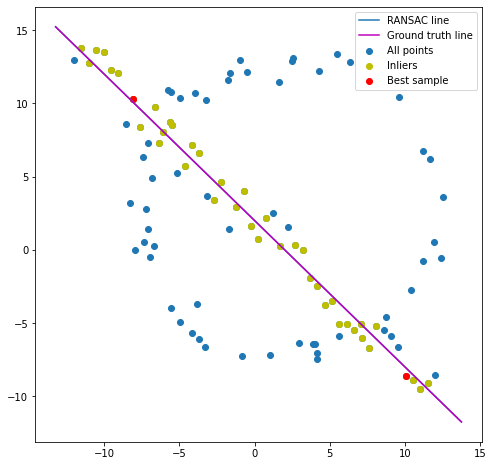

In [4]:
import math

num_points = X.shape[0]
X_ = X

def line_equation_from_points(x1, y1, x2, y2):
    
    b = x2 - x1
    a = y2 - y1

    magnitude = math.sqrt(b**2 + a**2)
    a = a / magnitude
    b = -b / magnitude

    d = (a * x1) + (b * y1)

    # Return the line equation
    return a, b, d

# RANSAC to fit a line
def tls_line(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))

# Constraint
def h(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': h})

# Computing the consensus (inliers)
def consensus_line(X, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t

threshold = 1.           # Threshold value to determine data points that are fit well by model.
d = 0.4*num_points           # Number of close data points required to assert that a model fits well to data.
s = 2                            # Minimum number of data points required to estimate model parameters.

inliers_line = []        # Indinces of the inliers
maximum_iterations = 50
iteration = 0
best_model_line = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_line = []    # Two-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, d) only using the best sample
best_inliers_line = []   # Inliers of the model computed form the best sample

while iteration < maximum_iterations:   
    i = np.random.randint(0, num_points, s)                                               #indices                                           # A sample of two (s) points selected at random
    x0 = np.array([1, 1, 0])                                                                        # Initial estimate
    res = minimize(fun = tls_line, args = i, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
    inliers_line = consensus_line(X_, res.x, threshold)                                 # Computing the inliers
    print('rex.x: ', res.x)    
    print('Iteration = ', iteration, '. No. inliners = ', inliers_line.sum())
    if inliers_line.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        res = minimize(fun = tls_line, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
        print(res.x, res.fun)
        if res.fun < best_error:
            print('A better model found ... ', res.x, res.fun)
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = X_[i,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1

print('Best line model', best_model_line)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X[:,0],X[:,1], label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

rex.x:  [ 3.9231436   6.05922388 12.45147016]
Iteration =  0 . No. inliners =  17
1.9724694381077355e-08
rex.x:  [0.06469131 8.53200198 7.28715433]
Iteration =  1 . No. inliners =  7
1.5270467687933515e-08
rex.x:  [ 2.12959795  3.13708573 10.11933026]
Iteration =  2 . No. inliners =  44
1.7023520795176247e-08
[ 2.1824688   3.01711997 10.13731044] 11.267111949632287
A better model found ...  [ 2.1824688   3.01711997 10.13731044] 11.267111949632287
rex.x:  [-14.4109451   10.          28.28492481]
Iteration =  3 . No. inliners =  9
0.5441447090858706
rex.x:  [ 4.59236875 -3.74951058  8.41382427]
Iteration =  4 . No. inliners =  8
7.261241288251423e-08
rex.x:  [-0.87892095 -7.72247568 10.48969722]
Iteration =  5 . No. inliners =  10
6.123223815704775e-10
rex.x:  [ 3.69373667  3.07187002 11.31076727]
Iteration =  6 . No. inliners =  27
3.282325006294059e-10
rex.x:  [ 3.37783806  0.61110631 12.5469323 ]
Iteration =  7 . No. inliners =  17
1.0300502903624479e-07
rex.x:  [-0.431414    3.906068

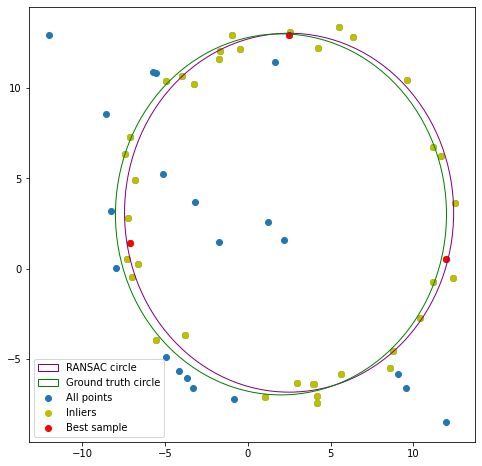

In [5]:
circle = X[~best_inliers_line]
X_ = circle 
num_points = circle.shape[0]



inliers_circle = []        
maximum_iterations = 50
iteration = 0
best_model_circle = []    
best_error = np.inf
best_sample_circle = []    
res_only_with_sample = [] 
best_inliers_circle = []   



def circle_tls(x, indices):
    a, b, r = x[0], x[1], x[2]
    return np.sum(np.square(np.sqrt(np.square(X_[indices,0] - a) + np.square(X_[indices,1] - b))-r))


def consensus_circle(X, x, t):
    a, b, r = x[0], x[1], x[2]
    error = np.absolute(np.sqrt(np.square(X_[:,0] - a) + np.square(X_[:,1] - b))-r)
    return error < t

def h(x):
    return [10 - x[0], 10 - x[1]]  


cons = ({'type': 'ineq', 'fun': h})

threshold = 1.   
d = 0.6*num_points   
s = 3       


while iteration < maximum_iterations:   
    i = np.random.randint(0, num_points, s) 
    x0 = np.array([1, 1, 1])
    res = minimize(fun = circle_tls, args = i, constraints = cons, x0 = x0, tol= 1e-6)
    inliers_circle = consensus_circle(X_, res.x, threshold)
    print('rex.x: ', res.x)    
    print('Iteration = ', iteration, '. No. inliners = ',  inliers_circle.sum())
    print(circle_tls(res.x, i))
    if inliers_circle.sum() > d:
        x0 = res.x
        
        res = minimize(fun = circle_tls, args = inliers_circle, x0 = x0, tol= 1e-6, constraints=cons)
        print(res.x, res.fun)
        if res.fun < best_error:
            print('A better model found ... ', res.x, res.fun)
            best_model_circle = res.x
            best_eror = res.fun
            best_sample_circle = X_[i,:]
            res_only_with_sample = x0
            best_inliers_circle = inliers_circle

    iteration += 1

print('Best circle model', best_model_circle)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(circle[:,0],circle[:,1], label='All points')
ax.scatter(X_[best_inliers_circle,0],X_[best_inliers_circle,1], color='y', label='Inliers')
ax.scatter(best_sample_circle[:,0],best_sample_circle[:,1], color='r', label='Best sample')
circle_gt = plt.Circle( ( best_model_circle[0] , best_model_circle[1] ) , best_model_circle[2] , color= 'purple' , fill =False , label=  'RANSAC circle' )
ax.add_patch(circle_gt)
circle_gt = plt.Circle( ( x0_gt , y0_gt ) , r , color= 'g' , fill =False , label=  'Ground truth circle' )
ax.add_patch(circle_gt)
plt.legend()



Question 3

In [2]:
import cv2
import numpy as np

# list to store the selected points
selected_points = []

# Callback function for mouse click events
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        # When the left mouse button is clicked, record the point
        selected_points.append([x, y])
        # Draw a circle at the selected point
        cv2.circle(image, (x, y), 5, (0, 0, 255), -1)
        cv2.imshow('Select Points', image)

# Load the image on which you want to select points
image = cv2.imread('001.jpg')

# Executing mouse callback function
cv2.imshow('Select Points', image)
cv2.setMouseCallback('Select Points', click_event)

# selecting four points
while len(selected_points) < 4:
    cv2.waitKey(1)

cv2.destroyAllWindows()
print("Selected Points:", selected_points)


Selected Points: [[319, 207], [316, 490], [48, 503], [59, 163]]


In [3]:
image2 = cv2.imread('1200px-Flag_of_the_United_States.svg.webp')

In [4]:
points_image1 = np.array(selected_points).astype('float32')
points_image2 = np.array([ [0,0], [image2.shape[1] , 0], [image2.shape[1], image2.shape[0]], [0, image2.shape[0]] ]).astype('float32')

In [5]:
homography_matrix= cv2.findHomography(points_image2 , points_image1)[0]

warped_image2 = cv2.warpPerspective(image2, homography_matrix, (image.shape[1], image.shape[0] ))

#using simple averaging to blend the images

alpha = 0.5
blended_image = cv2.addWeighted(image, alpha, warped_image2, 1- alpha, 0)

# Display the result
cv2.imshow('Superimposed Image', blended_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Save the result
cv2.imwrite('superimposed_image.jpg', blended_image)


True

(-0.5, 1023.5, 767.5, -0.5)

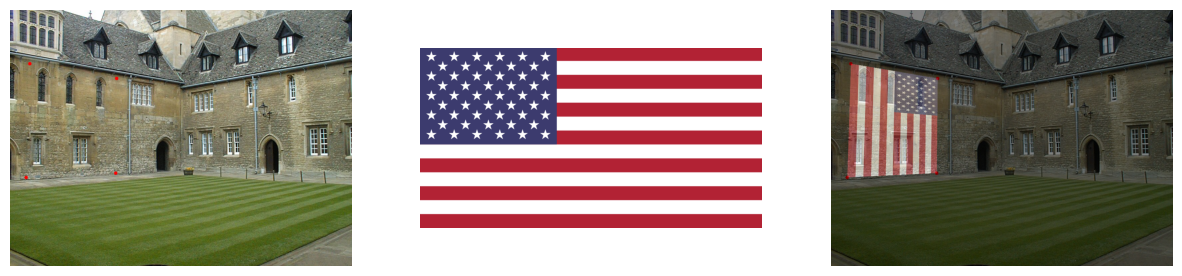

In [16]:
import matplotlib.pyplot as plt


image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
blended_image = cv2.cvtColor(blended_image,cv2.COLOR_BGR2RGB)

plt.figure(figsize = (15,5))


plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(image2)
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(blended_image)
plt.axis('off')


Question 4

In [26]:
def sift_match(img1, img2):

    GMP = 0.8

    # Detect sift features
    s = cv.SIFT_create(nOctaveLayers=3, contrastThreshold=0.1, edgeThreshold=25, sigma=1)
    kpts1, desc1 = s.detectAndCompute(img1, None)
    kpts2, desc2 = s.detectAndCompute(img2, None)

    # Match features.
    m = cv.BFMatcher()
    matches = m.knnMatch(desc1, desc2, k=2)

    # Filter good matches using ratio test in Lowe's paper
    good_matches, pts1, pts2 = [], [], []

    for m1, m2 in matches:
        if m1.distance < GMP * m2.distance:
            good_matches.append(m1)
            pts1.append(kpts1[m1.queryIdx].pt)
            pts2.append(kpts2[m1.trainIdx].pt)

    good_matches, pts1, pts2 = np.array(good_matches), np.array(pts1), np.array(pts2)

    # Plot the matching
    f, a = plt.subplots(figsize=(15, 15))
    a.axis('off')
    m_img = cv.drawMatches(img1, kpts1, img2, kpts2, good_matches, img2, flags=2)
    plt.imshow(cv.cvtColor(m_img, cv.COLOR_BGR2RGB))
    plt.show()

    return pts1, pts2


In [27]:
def homography(points1, points2):
    '''Determining the homography between the two sets of points'''
    matrix_A = []
    for i in range(len(points1)):
        x1, y1, x2, y2 = points1[i][0], points1[i][1], points2[i][0], points2[i][1]
        matrix_A.append([-x1, -y1, -1, 0, 0, 0, x2 * x1, x2 * y1, x2])
        matrix_A.append([0, 0, 0, -x1, -y1, -1, y2 * x1, y2 * y1, y2])

    matrix_A = np.matrix(matrix_A)
    U, S, V = np.linalg.svd(matrix_A)
    homography_matrix = np.reshape(V[-1], (3, 3))
    homography_matrix = (1 / homography_matrix.item(8)) * homography_matrix
    return homography_matrix


In [28]:
def dist(Pa, Pb, Hm):
    '''Calculate the distance between two points belonging to the two images'''
    p1 = np.transpose(np.matrix([Pa[0], Pa[1], 1]))
    estimated_p2 = np.dot(Hm, p1)
    estimated_p2 = (1 / estimated_p2.item(2)) * estimated_p2

    p2 = np.transpose(np.matrix([Pb[0], Pb[1], 1]))
    error = p2 - estimated_p2
    return np.linalg.norm(error)

def RANSAC_homography(pts1, pts2):
    inlier_count, selected_inliers = 0, None

    concatenated_pts = np.hstack((pts1, pts2))
    num_iterations = int(np.log(1 - 0.95) / np.log(1 - (1 - 0.5) ** 4))
    threshold = 100

    for i in range(num_iterations):
        sample_pts1, sample_pts2 = [], []
        for k in range(4):
            idx = np.random.randint(0, len(pts1))
            sample_pts1.append(pts1[idx])
            sample_pts2.append(pts2[idx])

        H_matrix = homography(sample_pts1, sample_pts2)

        inliers_list1, inliers_list2 = [], []

        for j in range(len(pts1)):
            distance = dist(pts1[j], pts2[j], H_matrix)
            if distance < 5:
                inliers_list1.append(pts1[j])
                inliers_list2.append(pts2[j])

        if len(inliers_list1) > threshold:
            max_inliers_list1 = inliers_list1
            max_inliers_list2 = inliers_list2
            H_matrix = homography(max_inliers_list1, max_inliers_list2)

    return H_matrix


In [24]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import linalg

# Import images
img1 = cv.imread('img1.ppm')   
img5 = cv.imread('img5.ppm')

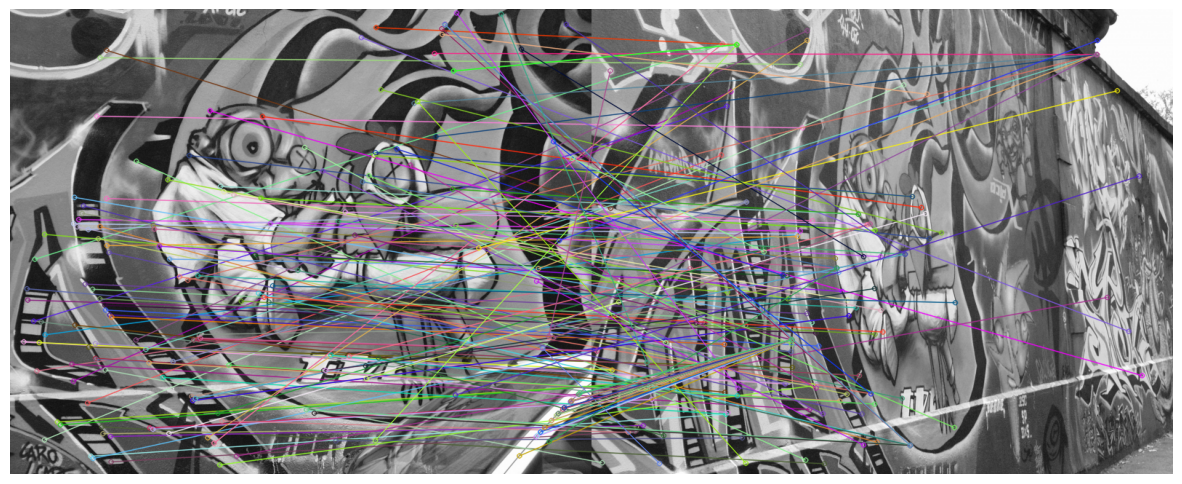

[[ 4.34650027e-02 -9.86081996e-01  2.96505847e+02]
 [ 5.59251376e-02 -1.47362724e+00  4.48989310e+02]
 [ 1.27873102e-04 -3.28873805e-03  1.00000000e+00]]


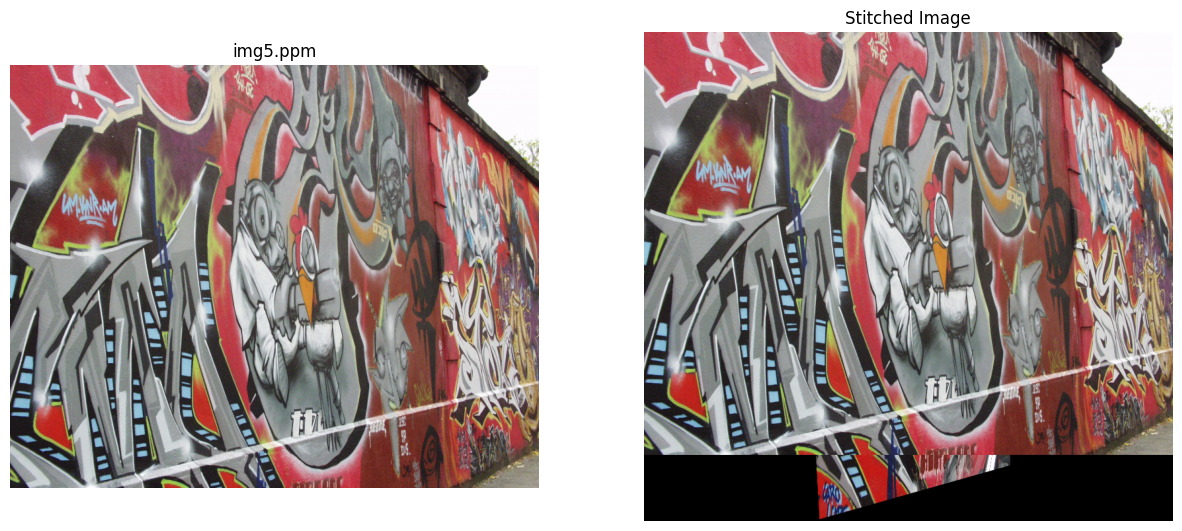

In [25]:
img1_gray = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
img5_gray = cv.cvtColor(img5, cv.COLOR_BGR2GRAY)

#Computing and matching SIFT features between the two images
points1, points2 = sift_match(img1_gray,img5_gray)

#Computing the homography using RANSAC
H = RANSAC_homography(points1, points2)
print(H)

#From H1to5p we obtain the value for H as,
H = np.array([[6.2544644e-01,   5.7759174e-02,   2.2201217e+02],
   [2.2240536e-01,   1.1652147e+00,  -2.5605611e+01],
   [4.9212545e-04,  -3.6542424e-05,  1.0000000e+00]])

#Finally we stich the two images img1 and img5
img_p = cv.warpPerspective(img1, H, (img5.shape[1], img5.shape[0]))

width = img1.shape[1] 
height = img1.shape[0] +100
img_p = cv.warpPerspective(img1, H, (width, height))
img_p[0:img5.shape[0], 0:img5.shape[1]] = img5

fig, ax = plt.subplots(1, 2, figsize=(15, 12))
ax[0].imshow(cv.cvtColor(img5,cv.COLOR_BGR2RGB))
ax[0].set_title("img5.ppm")
ax[0].axis("off")
ax[1].imshow(cv.cvtColor(img_p,cv.COLOR_BGR2RGB))
ax[1].set_title("Stitched Image")
ax[1].axis("off")

plt.show()